# Random Forest Forecast

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import DataFrame
import pickle
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('lawas-rainfall-daily.csv', encoding='latin')
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%Y-%m-%d")
df.set_index("DateTime",inplace=True)
# df['Wind Speed'] = df['Wind Speed'].replace(np.nan, 0)
# df = df.fillna(method='ffill')

Feature Engineering

In [16]:
# Define the sets of features for interaction
source1 = ['Rainfall']
source2 = ['TOTAL', 'ClimAdjust', 'ANOM']
source3 = ['Temperature', 'DewPoint', 'Humidity', 'WindSpeed', 'Pressure']

# Create interaction features
for s1 in source1:
    for s2 in source2:
        # Interaction between source1 and source2
        interaction_term = f'{s1}_{s2}'
        df[interaction_term] = df[s1] * df[s2]
        
    for s3 in source3:
        # Interaction between source1 and source3
        interaction_term = f'{s1}_{s3}'
        df[interaction_term] = df[s1] * df[s3]
        
for s2 in source2:
    for s3 in source3:
        # Interaction between source2 and source3
        interaction_term = f'{s2}_{s3}'
        df[interaction_term] = df[s2] * df[s3]
        
print(df.columns.to_list())

['Rainfall', 'TOTAL', 'ClimAdjust', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'WindSpeed', 'Pressure', 'Wind', 'Condition', 'Rainfall_TOTAL', 'Rainfall_ClimAdjust', 'Rainfall_ANOM', 'Rainfall_Temperature', 'Rainfall_DewPoint', 'Rainfall_Humidity', 'Rainfall_WindSpeed', 'Rainfall_Pressure', 'TOTAL_Temperature', 'TOTAL_DewPoint', 'TOTAL_Humidity', 'TOTAL_WindSpeed', 'TOTAL_Pressure', 'ClimAdjust_Temperature', 'ClimAdjust_DewPoint', 'ClimAdjust_Humidity', 'ClimAdjust_WindSpeed', 'ClimAdjust_Pressure', 'ANOM_Temperature', 'ANOM_DewPoint', 'ANOM_Humidity', 'ANOM_WindSpeed', 'ANOM_Pressure']


In [17]:
# Create rolling statistics for 24, 48, 72 hours (1, 2, 3 days)
for window in [7,14,30]:
    df[f"Rainfall_{window}d_mean"] = df["Rainfall"].rolling(window).mean()
    df[f"Rainfall_{window}d_std"] = df["Rainfall"].rolling(window).std()
    df[f"Rainfall_{window}d_sum"] = df["Rainfall"].rolling(window).sum()

In [18]:
for lag in range(1, 31):
    df[f'Rainfall_lag_{lag}'] = df['Rainfall'].shift(lag)

In [19]:
df.dropna(inplace=True)

                        Rainfall     TOTAL  ClimAdjust      ANOM  Temperature  \
Rainfall                1.000000 -0.058323   -0.055054 -0.035081    -0.193827   
TOTAL                  -0.058323  1.000000    0.483680  0.864335     0.320097   
ClimAdjust             -0.055054  0.483680    1.000000 -0.022075     0.297113   
ANOM                   -0.035081  0.864335   -0.022075  1.000000     0.195400   
Temperature            -0.193827  0.320097    0.297113  0.195400     1.000000   
DewPoint                0.002005  0.201905    0.313259  0.050761     0.447196   
Humidity                0.204206 -0.152459   -0.030518 -0.157000    -0.639897   
WindSpeed              -0.002468 -0.020862   -0.199787  0.090335    -0.009859   
Pressure               -0.019396  0.222135   -0.083975  0.301865    -0.211398   
Rainfall_TOTAL          0.999096 -0.038557   -0.046218 -0.017577    -0.189377   
Rainfall_ClimAdjust     0.999814 -0.053905   -0.045982 -0.035245    -0.191879   
Rainfall_ANOM          -0.11

<Axes: >

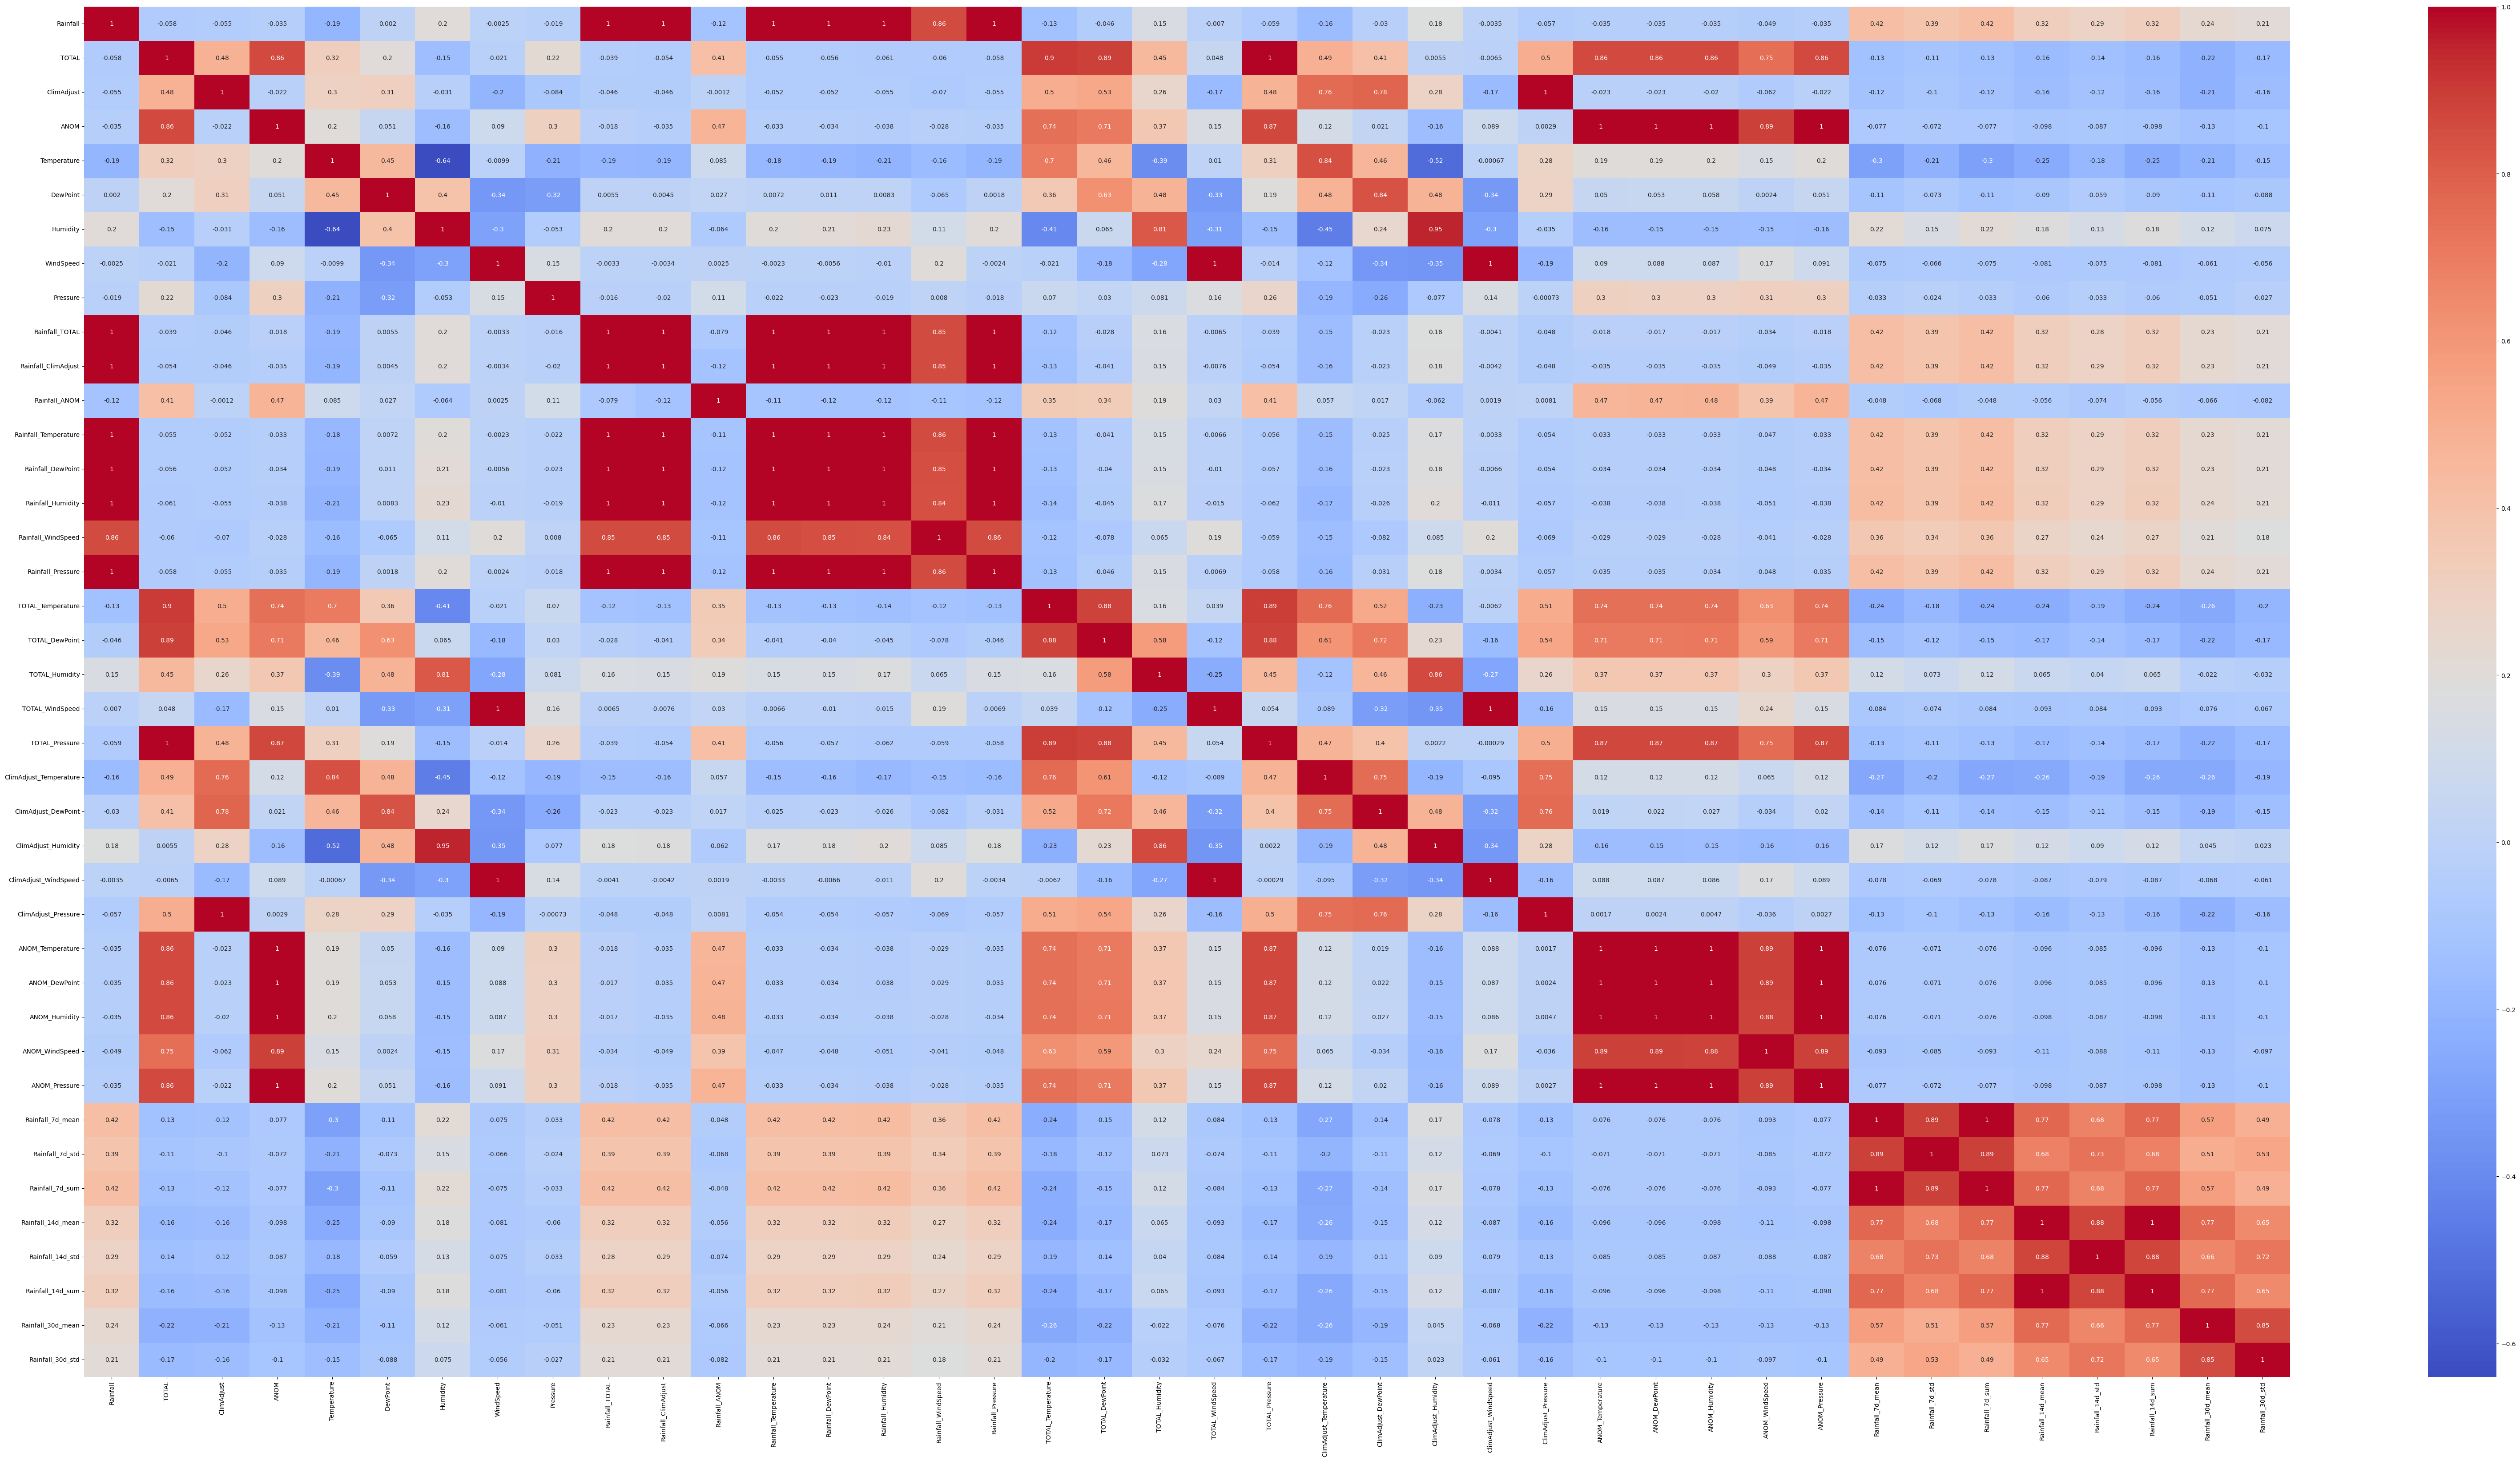

In [20]:
corr_matrix = df.iloc[:, :42].corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(80,40))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

Dimensionality Reduction

In [21]:
# Dimensionality Reduction
low_corr_features = corr_matrix['Rainfall'][corr_matrix['Rainfall'].abs() < 0.1].index.tolist()
print(f"Features with low correlation to Rainfall: {low_corr_features}")

Features with low correlation to Rainfall: ['TOTAL', 'ClimAdjust', 'ANOM', 'DewPoint', 'WindSpeed', 'Pressure', 'TOTAL_DewPoint', 'TOTAL_WindSpeed', 'TOTAL_Pressure', 'ClimAdjust_DewPoint', 'ClimAdjust_WindSpeed', 'ClimAdjust_Pressure', 'ANOM_Temperature', 'ANOM_DewPoint', 'ANOM_Humidity', 'ANOM_WindSpeed', 'ANOM_Pressure']


In [22]:
df_dim_red = df.drop(columns=low_corr_features)
df_dim_red = df_dim_red.select_dtypes(include=['number'])

                        Rainfall  Temperature  Humidity  Rainfall_TOTAL  \
Rainfall                1.000000    -0.193827  0.204206        0.999096   
Temperature            -0.193827     1.000000 -0.639897       -0.189377   
Humidity                0.204206    -0.639897  1.000000        0.202724   
Rainfall_TOTAL          0.999096    -0.189377  0.202724        1.000000   
Rainfall_ClimAdjust     0.999814    -0.191879  0.204401        0.999296   
Rainfall_ANOM          -0.116691     0.085097 -0.064395       -0.078994   
Rainfall_Temperature    0.999716    -0.182718  0.197214        0.999035   
Rainfall_DewPoint       0.999798    -0.188821  0.206561        0.999045   
Rainfall_Humidity       0.998387    -0.210211  0.226763        0.997272   
Rainfall_WindSpeed      0.855958    -0.161290  0.111226        0.854068   
Rainfall_Pressure       0.999998    -0.194014  0.204202        0.999106   
TOTAL_Temperature      -0.133381     0.701050 -0.408646       -0.116576   
TOTAL_Humidity          0

<Axes: >

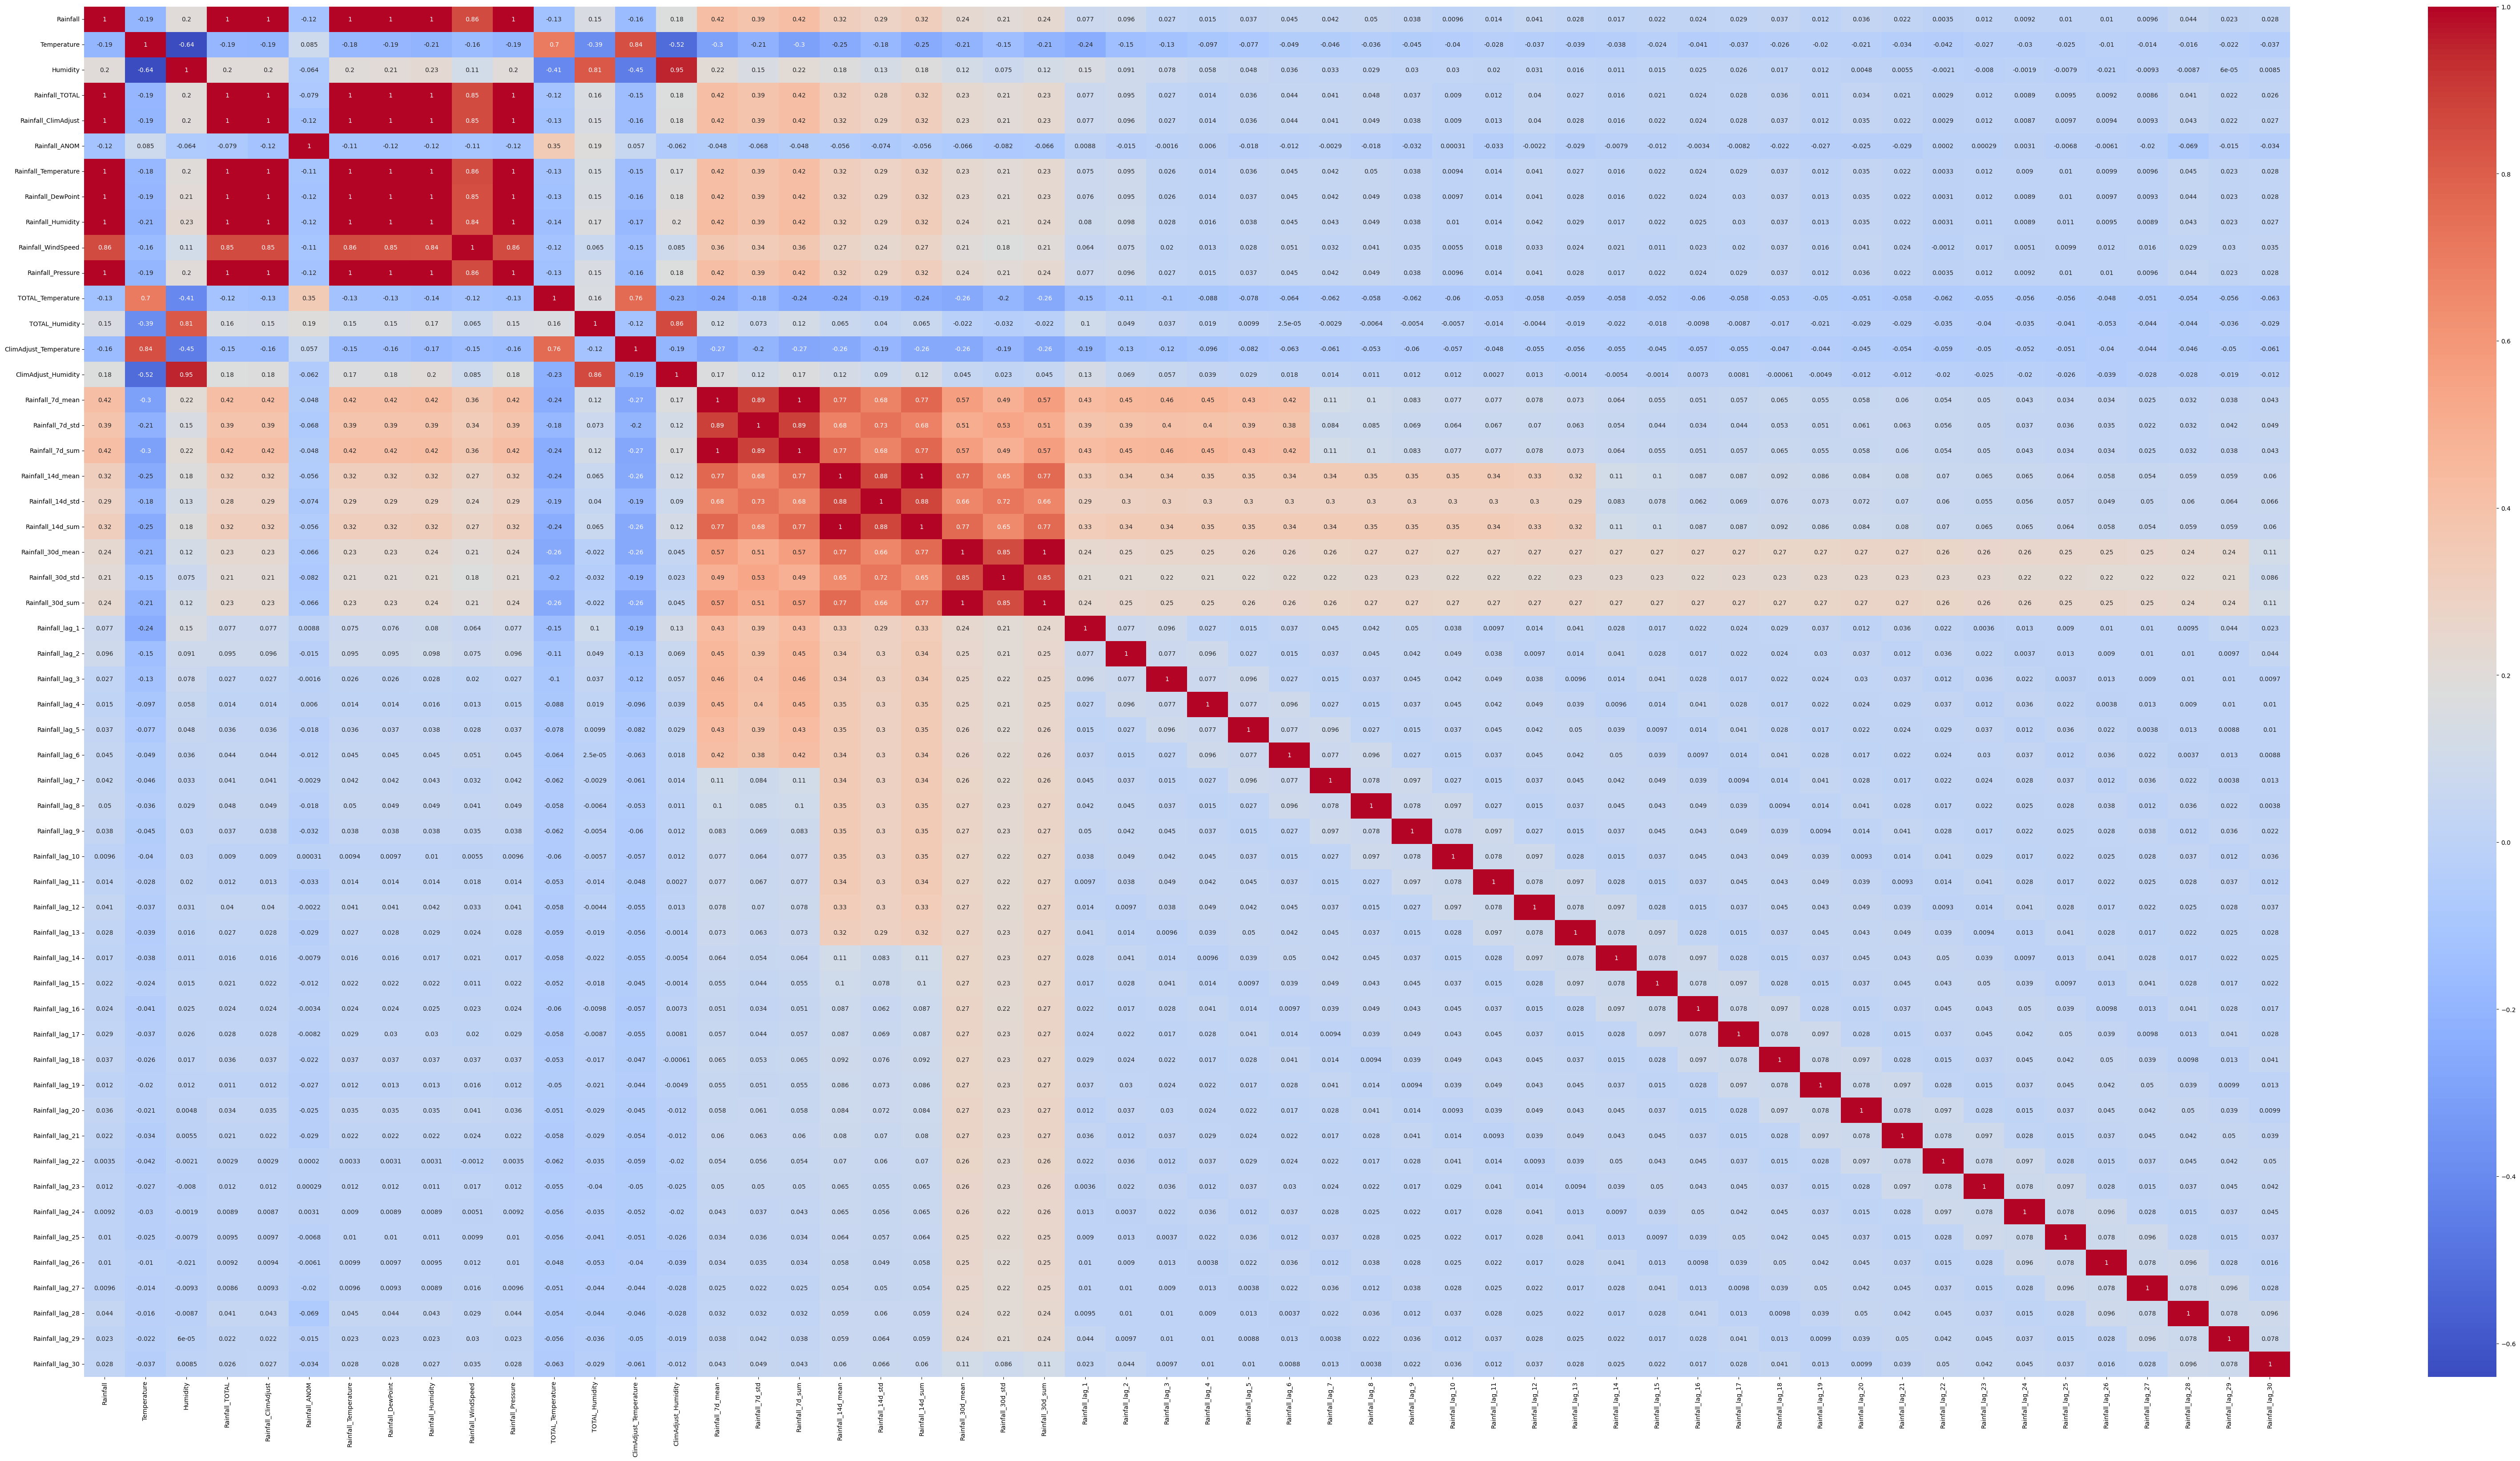

In [23]:
corr_matrix = df_dim_red.corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(80,40))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
d:\rf-rainfall-forecast\.virt\Lib\site-packages\sklearn\base.py:493: UserWarning: X d

Actual rainfall for the next 30 days:
[ 4.   0.   0.   0.  22.   0.  82.5 12.  16.5  1.5  2.   7.  22.  28.
  1.  25.5  0.5 33.  16.5 19.5  4.5  1.5  0.  61.5  4.   9.   0.  13.5
  4.   0. ]
Predicted rainfall for the next 30 days:
[ 3.75        4.         67.35779817 75.27408257 70.01146789 75.39449541
  4.71100917  1.79357798  8.72018349  7.95183486  7.80963303 11.
  3.5         0.93577982 11.06192661  3.62385321  1.13302752  5.35091743
  4.16743119  0.74541284  5.26146789  3.5         1.05963303  3.5
  0.          0.68807339  0.72706422  0.62155963  3.5         0.5       ]


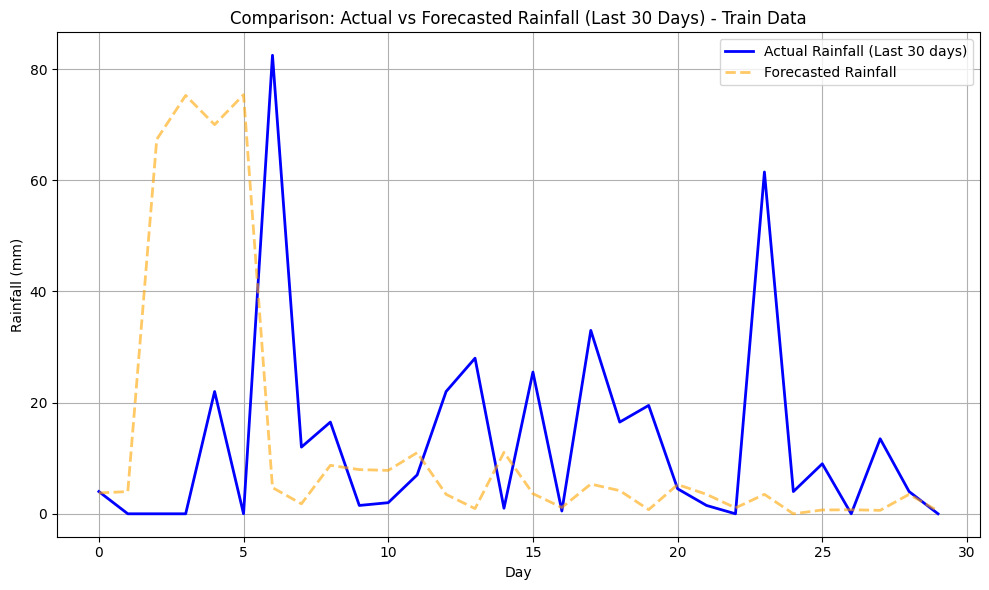

In [24]:

# Select features and target
# data_input = df[['Rainfall (mm)', 'ANOM', 'Temperature', 'Dew Point', 'Humidity', 'Wind Speed', 'Pressure']]

# Scaling the features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Function to create lagged features for all columns in the dataframe
def create_lagged_features(df, num_lags):
    df_lagged = DataFrame()
    for col in df.columns:
        for i in range(num_lags, 0, -1):
            df_lagged[f'{col}_t-{i}'] = df[col].shift(i)
    df_lagged['Current_Rainfall'] = df['Rainfall (mm)']
    df_lagged.dropna(inplace=True)
    return df_lagged

# Create lagged dataset for forecasting using all columns
# num_lags = 72  # Number of lagged values to use for forecasting
# df_lagged = create_lagged_features(data_input, num_lags)

# Separate features (lags of all columns) and target (Current_Rainfall)
features = df_dim_red.drop(columns=['Rainfall']).reset_index(drop=True)
target = df_dim_red['Rainfall']

# Scale features and target
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.30, random_state=100, shuffle=False)

# Train Random Forest Regressor
# rf = RandomForestRegressor(max_depth = 10, max_features = 'sqrt', min_samples_leaf = 10, min_samples_split = 2, n_estimators = 1000)
rf = RandomForestRegressor(max_depth = 19, max_features = None, min_samples_leaf = 1, min_samples_split = 3, n_estimators = 218, bootstrap=False)
rf.fit(x_train, y_train.ravel())


# with open("RF_model.pkl", 'wb') as file:  
#     pickle.dump(rf, file)

# with open('RF_model.pkl', 'rb') as f:
#     rf = pickle.load(f)

# Forecasting function
def forecast(model, initial_input, num_steps, feature_scaler, target_scaler):
    predictions = []
    current_input = initial_input

    for i in range(num_steps):
        current_input_scaled = feature_scaler.transform(current_input.reshape(1, -1))
        pred_scaled = model.predict(current_input_scaled)
        pred = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
        predictions.append(pred[0][0])

        # Shift the input to include the new prediction as the latest 'lag'
        current_input = np.roll(current_input, -1)
        current_input[-1] = pred[0][0]

    return np.array(predictions)

# Forecast future values
forecast_length = 30  # For example, forecasting the next 30 days
initial_input = df_dim_red.iloc[-forecast_length, :-1].values  # Take the last available data point as the starting input
predictions = forecast(rf, initial_input, forecast_length, feature_scaler, target_scaler)

# Get the actual rainfall data for the 30 days before the last observation
actual_rainfall_last_30_days = df_dim_red['Rainfall'].values[-forecast_length:]

# Actual values
print(f"Actual rainfall for the next {forecast_length} days:")
print(actual_rainfall_last_30_days)

# Output results
print(f"Predicted rainfall for the next {forecast_length} days:")
print(predictions)

# Plot forecasted vs actual values
plt.figure(figsize=(10, 6))

# Plot actual rainfall (30 days before the last observation)
plt.plot(range(forecast_length), actual_rainfall_last_30_days, label=f'Actual Rainfall (Last {forecast_length} days)', color='blue', linestyle='-', linewidth=2)

# Plot forecasted rainfall
plt.plot(range(forecast_length), predictions, label='Forecasted Rainfall', color='orange', alpha=0.6, linestyle='--', linewidth=2)

# Labels and title
plt.xlabel('Day')
plt.ylabel('Rainfall (mm)')
plt.title(f'Comparison: Actual vs Forecasted Rainfall (Last {forecast_length} Days) - Train Data')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Evaluation Metrics:
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 25.08
Root Mean Squared Error (RMSE): 5.01
R² Score: 0.95


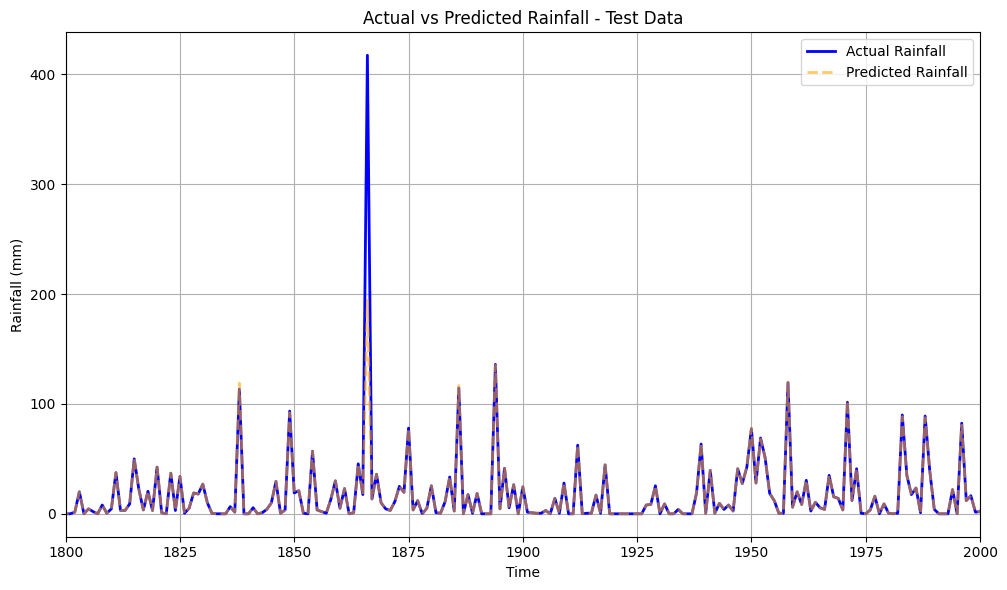

In [25]:
# Predict on the test set
y_pred_scaled = rf.predict(x_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # Convert predictions back to original scale
y_test_original = target_scaler.inverse_transform(y_test).ravel()  # Convert test targets back to original scale

test_result = pd.DataFrame({
    'y_pred': y_pred,
    'y_test_original': y_test_original
})

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Rainfall', color='blue', linestyle='-', linewidth=2)
plt.plot(y_pred, label='Predicted Rainfall', color='orange', alpha=0.6, linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Rainfall (mm)')
plt.title('Actual vs Predicted Rainfall - Test Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(1800,2000)
plt.show()

Save Model

In [26]:
with open("RF_model1.pkl", 'wb') as file:  
    pickle.dump(rf, file)

HyperParameter Tuning using Sci-kit Learn

In [27]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 500, 1000],  # Number of trees in the forest
#     'max_depth': [10, 20, 30, None],  # Maximum depth of the trees
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
#     'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
# }

# # Initialize the model
# rf = RandomForestRegressor(random_state=100)

# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit the model
# grid_search.fit(x_train, y_train.ravel())

# # Best parameters
# print("Best Hyperparameters:", grid_search.best_params_)

Hyperparameter Tuning using Optuna

In [28]:
# import optuna
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Define the objective function
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000)
#     max_depth = trial.suggest_int('max_depth', 10, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
#     bootstrap = trial.suggest_categorical('bootstrap', [True, False])

#     rf = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         bootstrap=bootstrap,
#         n_jobs=-1
#     )

#     rf.fit(x_train, y_train)
#     y_pred = rf.predict(x_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     return rmse

# # Create a study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Best parameters
# print("Best Hyperparameters:", study.best_trial.params)